In [5]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import image_to_string


In [27]:
#Creating argument dictionary for the default arguments needed in the code. 
#00-Kaveri-page-001
#C:\Users\diyas\Downloads\opencv-text-detection\images\lebron_james.jpg
#C:\Users\diyas\Downloads\01FB15ECS008-page-001.jpg
args = {"image":r"C:\Users\diyas\Downloads\01FB15ECS008-page-001.jpg", "east":r"C:\Users\diyas\Downloads\opencv-text-detection\frozen_east_text_detection.pb", "min_confidence":0.5, "width":320, "height":320}

In [28]:

image = cv2.imread(args['image'])

#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (args["width"], args["height"])

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)

In [29]:
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])
  
#Forward pass the blob from the image to get the desired output layers
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < args["min_confidence"]:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

[INFO] loading EAST text detector...


In [30]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < args["min_confidence"]:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2.imshow("Text Detection", orig)
cv2.waitKey(0)

[INFO] text detection took 0.183961 seconds


-1

In [31]:
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	custom_config = r'--oem 3 --psm 6'
text=pytesseract.image_to_string(r, config=custom_config)


results.append(((startX, startY, endX, endY), text))


: fake or a



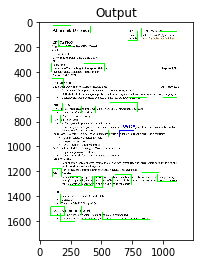

In [32]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 128 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()

In [33]:
boxes


array([[251,  14, 287,  25],
       [254,  60, 293,  73],
       [ 69,   6, 107,  16],
       [213,   9, 243,  22],
       [132, 279, 231, 290],
       [ 29,   5,  67,  16],
       [ 93,  61, 136,  72],
       [158, 224, 192, 239],
       [ 90, 277, 121, 290],
       [246, 223, 287, 234],
       [214, 221, 249, 232],
       [ 28, 215,  47, 228],
       [185,  13, 205,  27],
       [ 45, 252,  73, 267],
       [187,  98, 225, 111],
       [ 26,  60,  52,  73],
       [ 27,  83,  51,  95],
       [132, 228, 153, 242],
       [ 56, 270,  88, 283],
       [ 24, 271,  53, 284],
       [ 88, 123, 117, 134],
       [ 27, 119,  49, 130],
       [ 26, 137,  45, 148],
       [ 65, 227,  88, 240],
       [ 41,  26,  70,  36],
       [ 96,  29, 121,  40],
       [115, 227, 133, 243],
       [144, 158, 170, 169],
       [258, 100, 287, 111],
       [147, 118, 205, 132],
       [ 94, 226, 111, 240],
       [ 45, 280,  75, 293],
       [167, 159, 197, 169]])

In [34]:
text

': fake or a'

In [35]:
predictions

<function __main__.predictions>